In [1]:
library(ggplot2)
library(xts)
library(dplyr)
library(tidyr)
library(tseries)
library(forecast)
library(lubridate)
library(prophet)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Attaching package: 'dplyr'

The following objects are masked from 'package:xts':

    first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: Rcpp
Loading required package: rlang


In [2]:
data_runoff <- list.files(path='ObservedDischarge_LBRM_2011-2014', full.names=TRUE) %>% 
    lapply(function(f) {
        data <- read.fwf(f, c(8, 11), skip=2, col.names=c('date', 'runoff'))
        data$date <- ymd(strptime(gsub(' ', '0', data$date), '%d%m%Y'))
        data$lake <- rep(substr(f, 19,21), nrow(data))
        data$subbasin <- rep(strtoi(substr(f, 22,23)), nrow(data))
        data
    }) %>%
    Reduce(function(...) merge(..., all=TRUE), .)
           
data_forcing <- list.files(path='RDRS_daily_LBRM', full.names=TRUE) %>% 
    lapply(function(f) {
        data <- read.csv(f, sep=',', skip=3, col.names=c('date', 'tmin', 'tmax', 'prec'))
        data$date <- ymd(strptime(data$date, '%Y-%m-%d'))
        data$lake <- rep(substr(f, 26,28), nrow(data))
        data$subbasin <- rep(strtoi(substr(f, 29,30)), nrow(data))
        data
    }) %>%
    Reduce(function(...) merge(..., all=TRUE), .)
           
data <- full_join(data_forcing, data_runoff, by=c('date', 'lake', 'subbasin'))

In [3]:
eri02 <- data_runoff %>% filter(lake == 'eri' & subbasin == 2) %>% select(date, runoff)

In [18]:
saved <- options(repr.plot.width=10, repr.plot.height=10)
data_with_runoff <- data %>% filter(lake == 'eri' & subbasin == 2) %>% filter(date >= ymd('2011-01-01') & date <= ymd('2013-12-31'))
cut_date <- ymd('2013-01-01')
#par(mfrow=c(3,1))
#for (i in 1:3) {
train <- data_with_runoff %>% filter(date < cut_date) %>% select(date, runoff, prec, tmin, tmax)
train_y <- train %>% select(runoff)
#train_xreg <- data_with_runoff %>% filter(date < cut_date) %>% select(tmin, tmax, prec)
test_y <- data_with_runoff %>% filter(date >= cut_date & date < cut_date + years(1)) %>% select(runoff)
test_xreg <- data_with_runoff %>% filter(date >= cut_date & date < cut_date + years(1)) %>% select(tmin, tmax, prec)

fit <- prophet(yearly.seasonality=TRUE, weekly.seasonality=FALSE)
fit <- add_regressor(fit, 'prec')
fit <- add_regressor(fit, 'tmin')
fit <- add_regressor(fit, 'tmax')
m <- fit.prophet(fit, data.frame(ds=train$date, y=train$runoff, prec=train$prec, tmin=train$tmin, tmax=train$tmax))
future <- make_future_dataframe(m, periods=length(test_y[,1]))

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.


In [19]:
temp <- data_with_runoff %>% filter(date <= ymd('2013-12-31')) %>% select(prec,tmin,tmax)
future$prec <- temp[,1]
future$tmin <- temp[,2]
future$tmax <- temp[,3]

In [20]:
fcast <- predict(m, future)

In [28]:
fcast_cap <- sapply(fcast[['yhat']], function(y) max(y,0))

In [29]:
mse <- sum((fcast_cap - test_y[,1]) ^ 2) / length(fcast)
print(paste('MSE:', mse))

idx_start <- ymd('2011-01-01')

Warning message in fcast_cap - test_y[, 1]:
"longer object length is not a multiple of shorter object length"

[1] "MSE: 0.158352061814487"


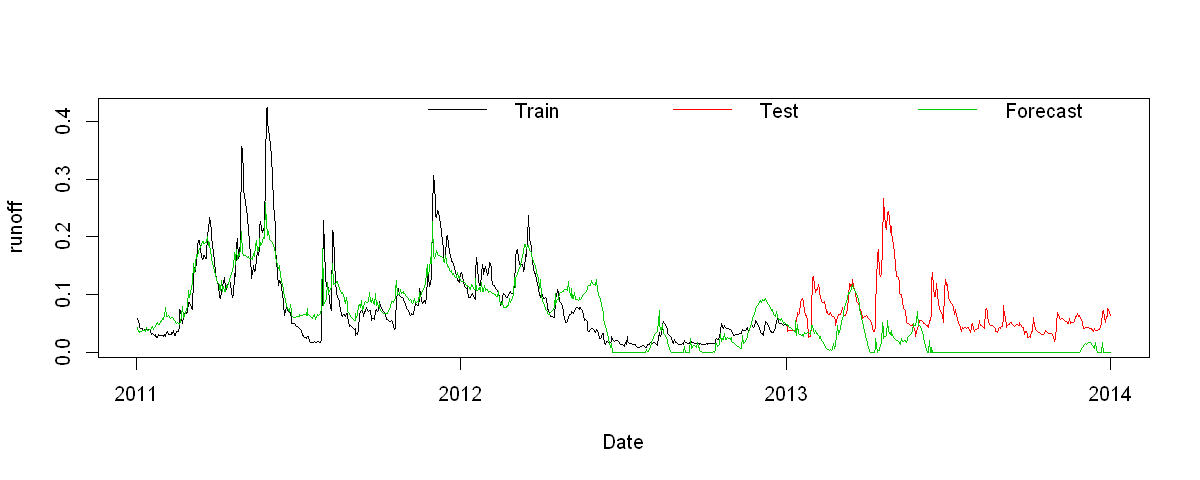

In [31]:
saved <- options(repr.plot.width=10, repr.plot.height=4)
plot_data <- c(train$runoff,rep(NA, 365))
plot(x=idx_start+days(index(plot_data)), y=plot_data, type='l', xlab='Date', ylab='runoff')
lines(x=idx_start+days(length(train[,1])+index(test_y)), y=test_y[,1], col=2)
lines(x=idx_start+days(index(plot_data)), y=fcast_cap, col=3)
legend("topright", legend=c("Train", "Test", "Forecast"), col=1:3, ncol=3, lty=1, bty='n')

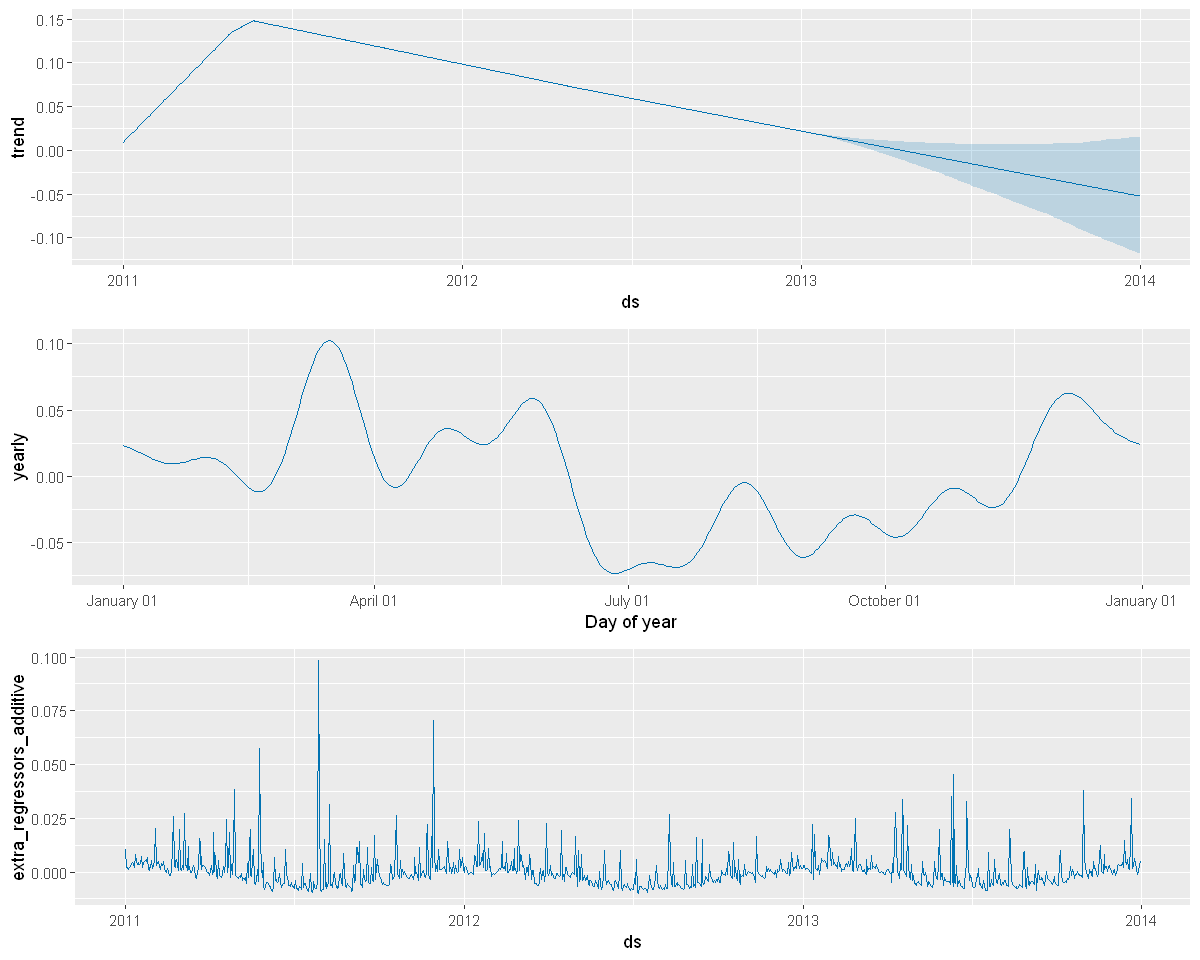

In [32]:
saved <- options(repr.plot.width=10, repr.plot.height=8)
prophet_plot_components(m, fcast)